In [1]:
import os
from matplotlib import pyplot
import numpy as np
import torch
from scipy.spatial.transform import Rotation
import pickle
from PIL import Image
from IPython.display import display
from ipywidgets import interact
from importlib import reload
import functools
import tqdm
import cv2
import contextlib

In [2]:
import face3drotationaugmentation.dataset300wlp as dataset300wlp
import face3drotationaugmentation.vis as vis
import face3drotationaugmentation.sampling as sampling
from face3drotationaugmentation.graphics import get_hpb, make_rot

In [3]:
with contextlib.closing(dataset300wlp.Dataset300WLP(os.path.join(os.environ['DATADIR'],'300W-LP.zip'))) as ds300wlp:
    all_rots = [ s['rot'] for s in tqdm.tqdm(ds300wlp) ]
    # Join rotations into a single array
    all_rots = Rotation.from_quat(np.asarray([ r.as_quat() for r in all_rots ]))

100%|██████████| 3837/3837 [00:19<00:00, 198.46it/s]


In [4]:
print (f"Number of frames: {len(all_rots)}")

Number of frames: 3837


In [5]:
deg2rad = np.pi/180.

In [6]:
def plot_euler_angle_bounds():
    fig = pyplot.figure(figsize=(20,15))
    hs = np.linspace(-110.,110.,221)
    p = 0.
    b = 0.
    h_ranges = np.asarray([ sampling.get_euler_angle_bounds_for_offset(make_rot([h,p,b]))[0] for h in (deg2rad*hs) ]) / deg2rad
    ax = pyplot.subplot(331)
    ax.plot(hs, h_ranges.T[0], label='h min')
    ax.plot(hs, h_ranges.T[1], label='h_max')
    ax.axhline(c = 'k')
    ax.axvline(c = 'k')
    ax.legend()
    axes = np.array([
        [
        pyplot.subplot(334),
        pyplot.subplot(335),
        pyplot.subplot(336)],
        [
        pyplot.subplot(337),
        pyplot.subplot(338),
        pyplot.subplot(339)
    ]])
    for i,h in enumerate(deg2rad*np.asarray([0., 45, 90.])):
        ax = axes[0,i]
        ps = np.linspace(-50.,50.,101)
        b = 0.
        p_ranges = np.asarray([ sampling.get_euler_angle_bounds_for_offset(make_rot([h,p,b]))[1] for p in (deg2rad*ps) ]) / deg2rad
        ax.plot(ps, p_ranges.T[0], label=f'p min @ h={h/deg2rad:0.1f}')
        ax.plot(ps, p_ranges.T[1], label=f'p_max @ h={h/deg2rad:0.1f}')
        ax.axhline(c = 'k')
        ax.axvline(c = 'k')
        ax.legend()

    for i,h in enumerate(deg2rad*np.asarray([0., 45, 90.])):
        ax = axes[1,i]
        bs = np.linspace(-30.,30.,61)
        p = 0.
        b_ranges = np.asarray([ sampling.get_euler_angle_bounds_for_offset(make_rot([h,p,b]))[2] for b in (deg2rad*bs) ]) / deg2rad
        ax.plot(bs, b_ranges.T[0], label=f'b min @ h={h/deg2rad:0.1f}')
        ax.plot(bs, b_ranges.T[1], label=f'b_max @ h={h/deg2rad:0.1f}')
        ax.axhline(c = 'k')
        ax.axvline(c = 'k')
        ax.legend()

    pyplot.tight_layout()
    pyplot.show()

plot_euler_angle_bounds()

AttributeError: module 'face3drotationaugmentation.sampling' has no attribute 'get_euler_angle_bounds_for_offset'

<Figure size 1440x1080 with 0 Axes>

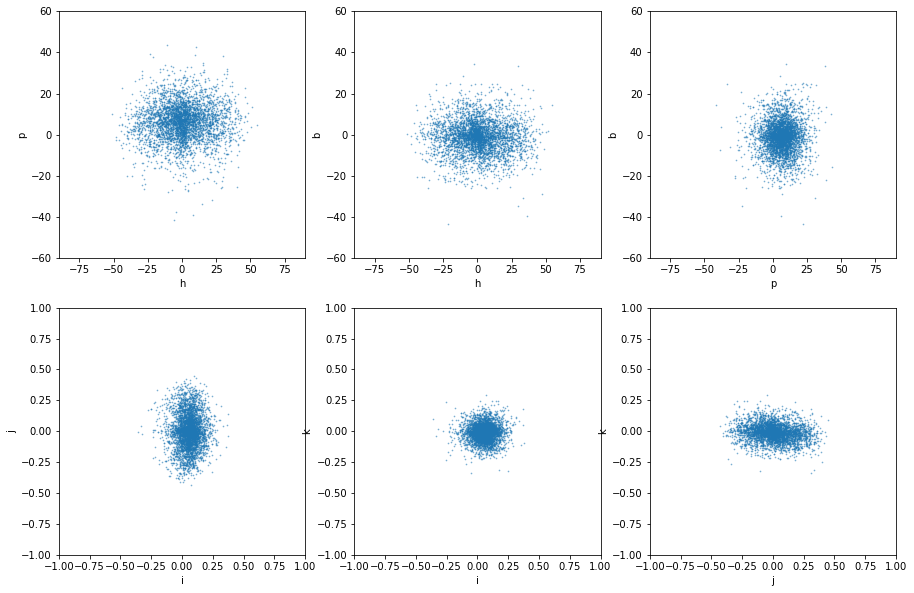

In [7]:
def plot_rotation_distribution(all_rots):
    hpb = get_hpb(all_rots)
    quats = all_rots.as_quat()
    fig, axes = pyplot.subplots(2,3, figsize=(15,10))
    axes = axes.ravel()
    ax = axes[0]
    names = 'h p b'.split()
    pairs = [ (0,1), (0,2), (1,2) ]
    for ax, (i,j) in zip(axes[:3],pairs):
        ax.scatter(hpb.T[i]/deg2rad, hpb.T[j]/deg2rad, s=0.5, alpha=0.5)
        ax.set(xlabel=names[i], ylabel=names[j])
        ax.set(xlim=(-90.,90.),ylim=(-60.,60.))
    names = 'i j k'.split()
    for ax, (i,j) in zip(axes[3:],pairs):
        ax.scatter(quats.T[i], quats.T[j], s=0.5, alpha=0.5)
        ax.set(xlabel=names[i], ylabel=names[j])
        ax.set(xlim=(-1.,1.),ylim=(-1.,1.))

plot_rotation_distribution(all_rots)

In [8]:
reload(sampling)

<module 'face3drotationaugmentation.sampling' from '/mnt/SSDNTFS/Programmierung/head-tracking/face-3d-rotation-augmentation/face3drotationaugmentation/sampling.py'>

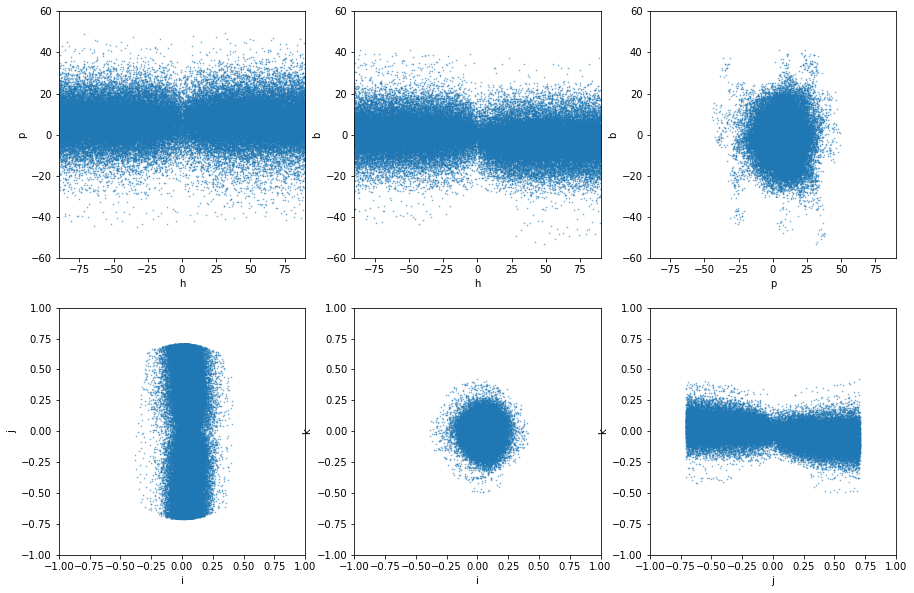

In [9]:
def concatenate_rot(rots):
    return Rotation.from_quat(np.stack(list(map(Rotation.as_quat, rots)), axis=0))

rng = np.random.RandomState()
synthetic_rots = concatenate_rot([ r for rot in all_rots for r in sampling.sample_more_face_params(rot,rng) ])
plot_rotation_distribution(synthetic_rots)

In [8]:
with contextlib.closing(dataset300wlp.Dataset300WLP(os.path.join(os.environ['DATADIR'],'300W-LP.zip'), only_originals=False)) as ds300wlpall:
    sample = ds300wlpall[100]  #[289]
    img = sample['image'].copy()
    vis.draw_pose(img, sample, 255, 2)
    all_rots = [ s['rot'] for s in tqdm.tqdm(ds300wlpall) ]

KeyError: 'DATADIR'

In [35]:
all_rots = concatenate_rot(all_rots)

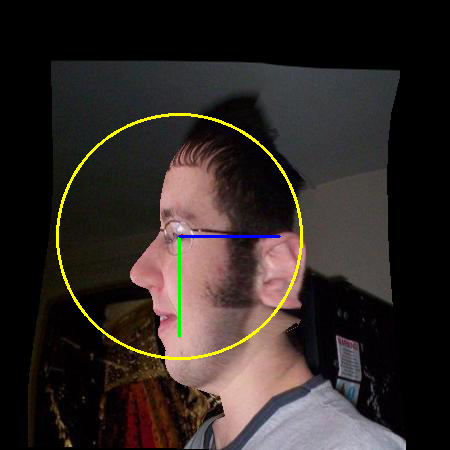

In [36]:
display(Image.fromarray(img))

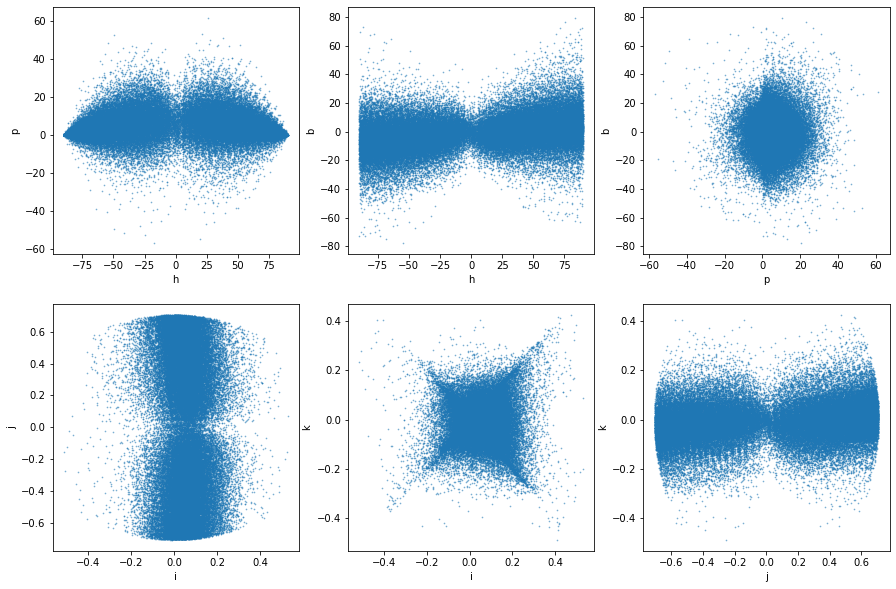

In [37]:
plot_rotation_distribution(all_rots)